______________________________________________________________________________
# A/B Testing for Conversion Rate Optimization
___________________________________________________________________

**A/B testing**:It is a user experience research methodology. A/B tests consist of a randomized experiment that usually involves two variants, although the concept can be also extended to multiple variants of the same variable.

### Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from scipy import stats
from collections import Counter
import warnings
from math import ceil
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
warnings.filterwarnings("ignore")

Choosing the variables
For our test we'll need two groups:

A control group - They'll be shown the old design
A treatment (or experimental) group - They'll be shown the new design
This will be our Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session
1 - The user bought the product during this user session
This way, we can easily calculate the mean for each group to get the conversion rate of each design.

Choosing a sample size
It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size we need is estimated through something called *Power analysis*, and it depends on a few factors:

Power of the test ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on statistical power, if you are curious)
Alpha value ($\alpha$) - The critical value we set earlier to 0.05
Effect size - How big of a difference we expect there to be between the conversion rates
Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [4]:
effect_size = sms.proportion_effectsize(0.13, 0.15)   

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                   

required_n = ceil(required_n)                                                    

print(required_n)

4720


 ### Calculating effect size based on our expected rates,Calculating sample size needed,Rounding up to next whole number 

In [5]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import math

effect_size = proportion_effectsize(0.13, 0.15)
power_analysis = NormalIndPower()

required_n = power_analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1,
)

required_n = math.ceil(required_n)

print(required_n)


4720


We'd need at least 4720 observations for each group.

Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

Dataset Link: https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

In [6]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [11]:
# check for  users that appear multiple times in a Dataset

multi_users =   len(df)-df['user_id'].nunique()

print(f"There are {multi_users} users that appear multiple times in the dataset")


There are 3894 users that appear multiple times in the dataset


In [15]:
# removing and Reupdating after removing these doubled users

df = df.drop_duplicates(subset='user_id', keep=False)
print(f"The updated dataset now has {df.shape[0]} entries")


The updated dataset now has 286690 entries



**Sampling**
Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [22]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0).reset_index(drop=True)


In [23]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9435,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9436,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9437,792022,2017-01-24 03:55:24.551307,treatment,new_page,0
9438,663570,2017-01-04 03:04:33.647683,treatment,new_page,0


In [25]:
# calculating conversion_rates 

conversion_rates = ab_test.groupby('group')['converted'].agg(['mean', 'std', 'sem']).rename(columns={'mean': 'conversion_rate', 'std': 'std_deviation', 'sem': 'std_error'})
conversion_rates = conversion_rates.round(3)
conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.320,0.005
treatment,0.129,0.335,0.005


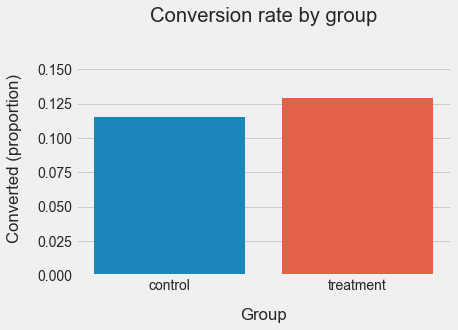

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
sns.barplot(data=ab_test, x='group', y='converted', ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()


The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So... the treatment group's value is higher. Is this difference statistically significant?

4. Testing the hypothesis
The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our $p$-value (i.e. z-test).

Again, Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the $p$-value and confidence intervals:

In [30]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [31]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.01
p-value: 0.044
ci 95% for control group: [0.106, 0.125]
ci 95% for treatment group: [0.119, 0.139]


### Conclusion:

Based on the A/B test results and statistical analysis, we cannot conclude that the new design performed significantly better than the old design. The p-value of 0.732, which is much higher than the significance level of 0.05, indicates that we cannot reject the null hypothesis. This means that there is not enough evidence to suggest a significant difference in conversion rates between the two designs.

Furthermore, the confidence interval for the treatment group (11.6% - 13.5%) includes the baseline conversion rate of 13% but does not include our target value of 15%. This suggests that it is more likely that the true conversion rate of the new design is similar to the baseline, rather than achieving the desired 2% uplift.

Therefore, based on the analysis, we can conclude that the new design did not perform significantly better than the old design. Further improvements or iterations may be required to achieve the desired conversion rate of 15%.

It is important to note that A/B testing is an iterative process, and this result provides valuable insights for future design changes and optimizations. By carefully analyzing the data and considering the statistical significance, we can make informed decisions to improve our designs and ultimately achieve better conversion rates.